In [2]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp

import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_1d_calcium_base as pl


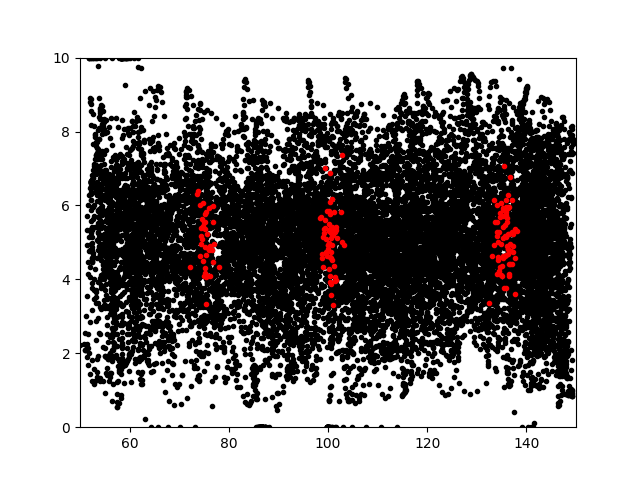

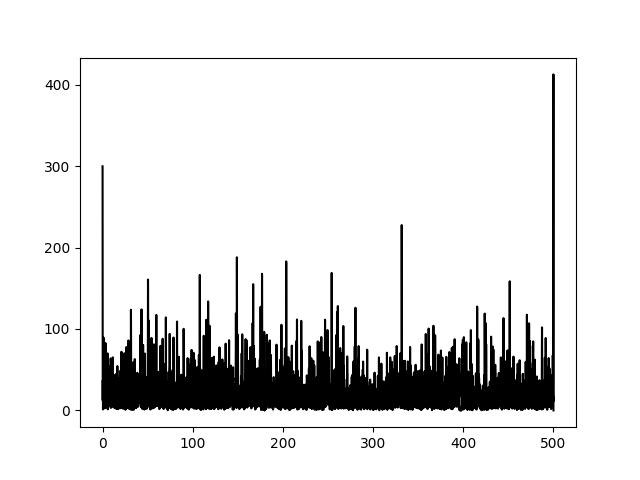

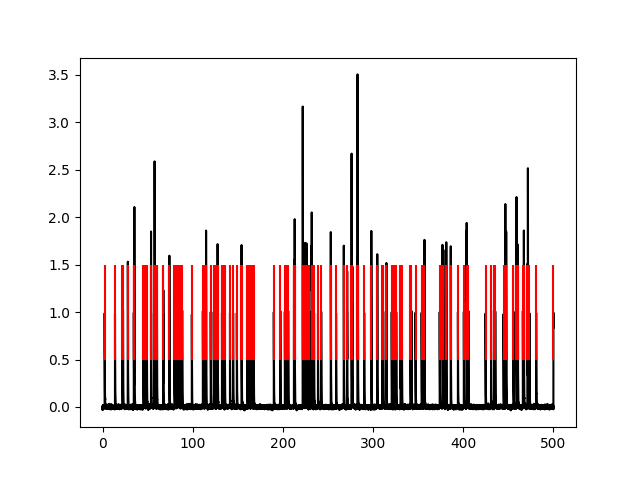

In [3]:

# Cell simulation parameters
sampling_rate = 30. # points/frames per second
duration = 500 # in seconds
rate = 10 # how much your neuron should spike
environment_edges = [[50,150],[0,10]] # in cm [[x_min,x_max],[y_min,y_max]]
smooth_time = 0.1
rho1 = 0.02
sigma = 1
mu_e = 0.

# Define field parameters
num_of_fields = 3

field1_center = (75, 5)
field2_center = (100, 5)
field3_center = (135, 5)
field1_size = 1
field2_size = 1
field3_size = 1

x_coordinates,y_coordinates,speed,speed_smoothed,time_vector = cs_model.generate_random_walk(input_srate = sampling_rate,input_total_Time = duration,heading_srate = 10., speed_srate = 5., rho1  = rho1,sigma = sigma,mu_e  = mu_e, smooth_points = int(np.round(smooth_time*sampling_rate)),environment_edges = environment_edges)

total_points = time_vector.shape[0]


spike_times = cs_model.generate_poisson_spikes(rate, duration)
spike_times_idx = (spike_times*sampling_rate).astype(int)


if num_of_fields == 0:
    modulated_spike_times_idx = spike_times_idx.copy()
else:
    modulated_spike_times_idx = []
    for counter in range(num_of_fields):
        field_center = eval('field' + str(counter+1) + '_center')
        field_size = eval('field' + str(counter+1) + '_size')
        modulated_spike_times_idx_aux = cs_model.digitize_spiketimes(x_coordinates,y_coordinates,spike_times_idx,x_center = field_center[0],y_center = field_center[1], s = field_size)
    
        modulated_spike_times_idx.append(modulated_spike_times_idx_aux)
    modulated_spike_times_idx = np.unique(np.concatenate(modulated_spike_times_idx)).astype(int)
    
signal,time_vector = cs_model.generate_calcium_signal(modulated_spike_times_idx,total_points,sampling_rate,noise_level = 0.01, b = 5.)
peaks_idx = dp.detect_peaks(signal,mpd=0.5*sampling_rate,mph=1.*np.nanstd(signal))


plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k.')
if len(modulated_spike_times_idx) > 0:
    plt.plot(x_coordinates[modulated_spike_times_idx],y_coordinates[modulated_spike_times_idx],color = 'red',linestyle='',marker='.',markersize=6)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal', 'box')
plt.show()

plt.figure()
plt.plot(time_vector,speed,'k')
plt.show()

plt.figure()
plt.plot(time_vector, signal,'k')
if len(modulated_spike_times_idx) > 0:
    plt.eventplot(time_vector[modulated_spike_times_idx],color='red')
plt.show()



'/home/apolo/Documents/github_projects'

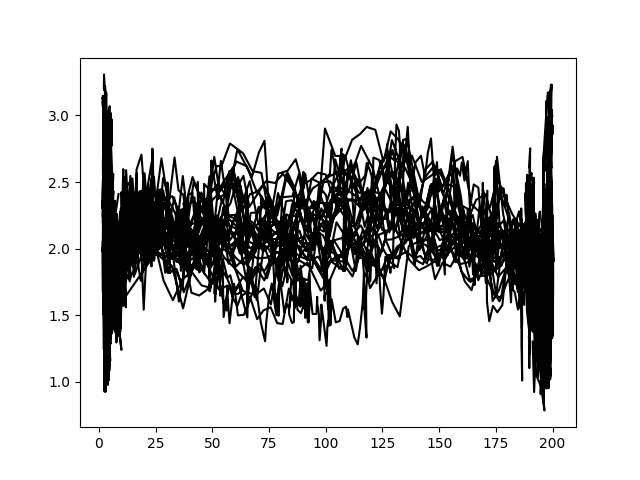

In [159]:
import pandas as pd
os.chdir('/home/apolo/Documents/github_projects/information_metrics/data/hanna/')

environment_edges = [[0,200],[0,4]] 


time_vector = np.load('time_vector.pickle',allow_pickle=True)
x_coordinates = np.load('x_coordinates.pickle',allow_pickle=True)
y_coordinates = np.load('y_coordinates.pickle',allow_pickle=True)
sampling_rate = 1/np.nanmean(np.diff(time_vector))

# Load the pickle file using pandas
df = pd.read_pickle('traces_neuron8.pickle')
signal = np.array(df)
signal_norm = hf.min_max_norm(signal,custom_min=0,custom_max=1)

plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k')
# plt.gca().set_aspect('equal', 'box')
plt.show()


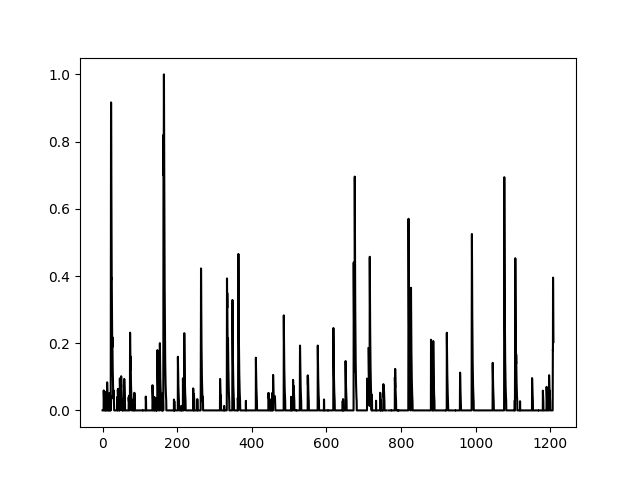

In [160]:
plt.figure()
plt.plot(time_vector,signal_norm,'k')
plt.show()

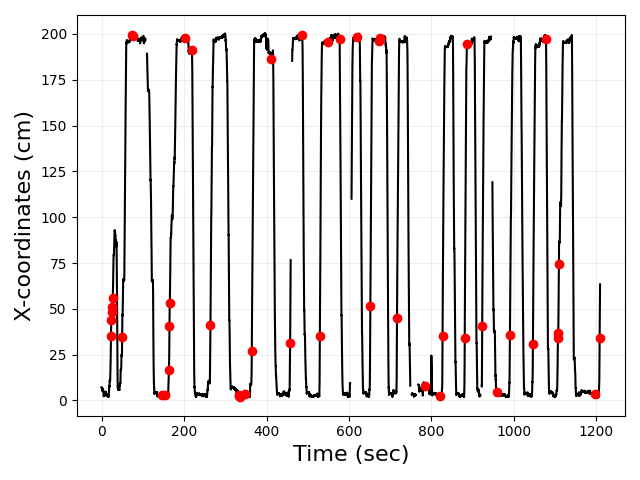

In [170]:
peaks_idx = dp.detect_peaks(signal,mpd=0.5*sampling_rate,mph=1.*np.nanstd(signal))

plt.close('all')
plt.figure()
plt.plot(time_vector, x_coordinates,color = 'black')
plt.plot(time_vector[peaks_idx], x_coordinates[peaks_idx],color = 'red',linestyle='',marker='o',markersize=6)

plt.ylabel('X-coordinates (cm)',fontsize=16)
plt.xlabel('Time (sec)',fontsize=16)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [230]:
trials_idx = (x_coordinates >= 10) & (x_coordinates <= 190)


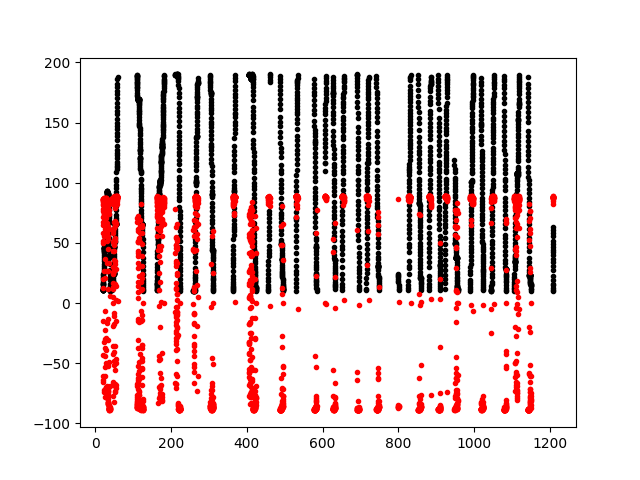

In [233]:
x_coordinates_trials = x_coordinates[trials_idx].copy()
time_vector_trials = time_vector[trials_idx].copy()

heading_direction_rad = np.arctan2(x_coordinates_trials[1:] - x_coordinates_trials[0:-1], time_vector_trials[1:] - time_vector_trials[0:-1])
heading_direction_deg = np.degrees(heading_direction_rad)

plt.figure()
plt.plot(time_vector_trials, x_coordinates_trials,'k.')
plt.plot(time_vector_trials[0:-1], heading_direction_deg,'r.')
plt.show()


In [262]:
def get_speed_1D(x_coordinates, time_vector,sigma_points=1):
    
    distances = np.diff(x_coordinates)

    time_vector_diff = np.diff(time_vector)

    speed = np.divide(distances, time_vector_diff)
    speed = np.hstack([speed, 0])
    speed_smoothed = hf.gaussian_smooth_1d(speed, sigma_points)

    return speed,speed_smoothed


In [271]:
velocity,velocity_smoothed = get_speed_1D(x_coordinates, time_vector,sigma_points=1)
speed,speed_smoothed = hf.get_speed_1D(x_coordinates, time_vector,sigma_points=6)


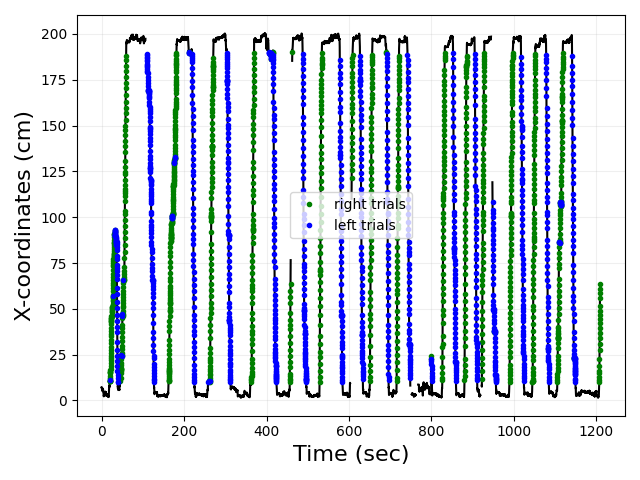

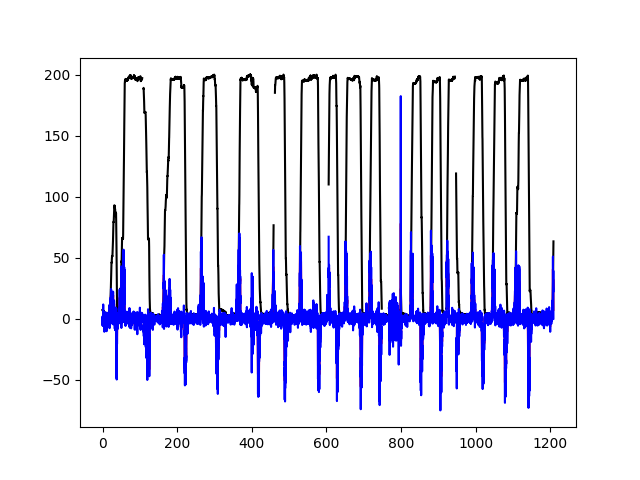

In [323]:
threshold_right = 1
threshold_left = -1

# np.where(velocity_smoothed < threshold_left)
trials_idx = (x_coordinates >= 10) & (x_coordinates <= 190)

velocity_right_idx = (velocity_smoothed > threshold_right)
velocity_left_idx = (velocity_smoothed < threshold_left)

trials_idx*velocity_right_idx
trials_idx*velocity_left_idx

plt.figure()
plt.plot(time_vector, x_coordinates,color = 'black')
plt.plot(time_vector[trials_idx*velocity_right_idx], x_coordinates[trials_idx*velocity_right_idx],'g.',label = 'right trials')
plt.plot(time_vector[trials_idx*velocity_left_idx], x_coordinates[trials_idx*velocity_left_idx],'b.',label = 'left trials')
plt.legend()

plt.ylabel('X-coordinates (cm)',fontsize=16)
plt.xlabel('Time (sec)',fontsize=16)
plt.grid(alpha=0.2)
plt.tight_layout()

plt.show()

plt.figure()
plt.plot(time_vector, x_coordinates,color = 'black')
plt.plot(time_vector, velocity_smoothed,color='red')
plt.plot(time_vector, velocity,color='blue')

plt.show()


In [309]:

trials = trials_idx*velocity_right_idx
# trials = trials_idx*velocity_left_idx



In [310]:
# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
# sampling_rate = 1/np.nanmean(np.diff(time_vector))

# now input_signal will point to the signal you choose
signal_type = 'Raw'
input_signal = hf.min_max_norm(signal,custom_min=0,custom_max=1)

# signal_type = 'Filtered'
# input_signal = filtered_signal

# signal_type = 'Diff'
# input_signal = diff_signal

# signal_type = 'Diff_truncated'
# input_signal = diff_signal_truncated



input_dict = dict()

# filename constructor
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['saving_path'] = None
input_dict['saving'] = False
 
input_dict['sampling_rate'] = sampling_rate # in points per second
input_dict['environment_edges'] = environment_edges # in cm

# inclusion criteria
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 
input_dict['speed_smoothing_points'] = int(np.round(0.1*sampling_rate)) # speed gaussian smoothing in seconds


# information parameters
input_dict['x_bin_size'] = 2 # x bin size in cm
input_dict['nbins_cal'] = 10

# surrogate parameters
input_dict['shift_time'] = 200
input_dict['num_cores'] = -1
input_dict['num_surrogates'] = 800

# place field parameters
input_dict['smoothing_size'] = 2
input_dict['percentile_threshold'] = 99
input_dict['min_num_of_pixels'] = 4

place_cell = pl.PlaceCell(**input_dict)
place_cell_output = place_cell.main(input_signal[trials],time_vector[trials],x_coordinates[trials])


SpatialMetrics.Raw.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


In [83]:
place_cell_output.keys()

dict_keys(['place_field', 'place_field_smoothed', 'place_field_shifted', 'place_field_smoothed_shifted', 'occupancy_map', 'visits_map', 'x_grid', 'x_center_bins', 'numb_events', 'x_peaks_location', 'events_amplitude', 'place_field_identity', 'num_of_islands', 'islands_x_max', 'sparsity', 'place_cell_extension_absolute', 'place_cell_extension_relative', 'mutual_info_original', 'mutual_info_shifted', 'mutual_info_zscored', 'mutual_info_centered', 'mutual_info_NN_original', 'mutual_info_NN_shifted', 'mutual_info_NN_zscored', 'mutual_info_NN_centered', 'input_parameters'])

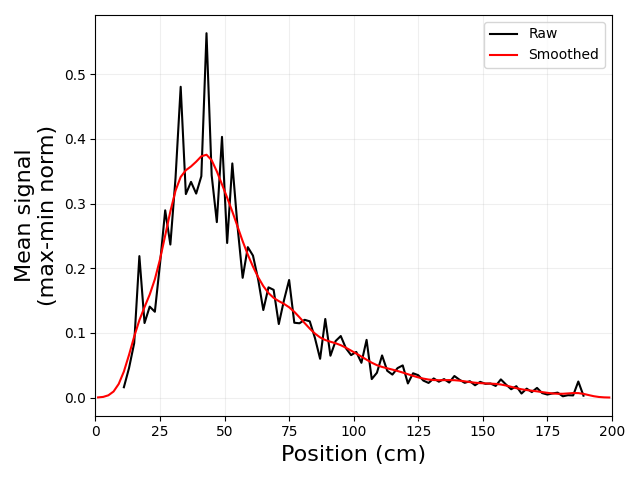

In [284]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


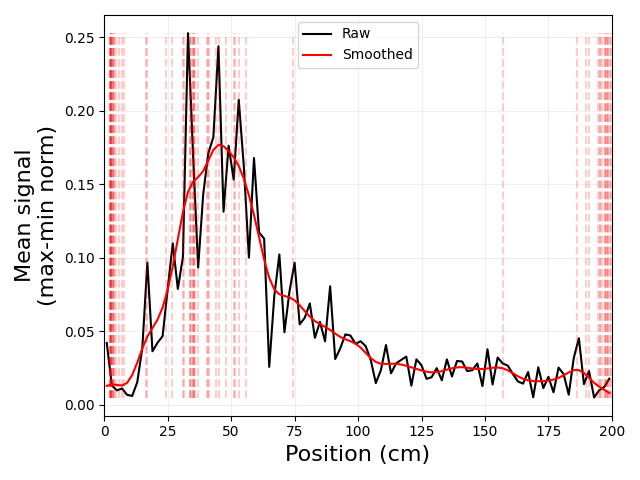

In [166]:


plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
plt.plot([place_cell_output['x_peaks_location'],place_cell_output['x_peaks_location']],[np.nanmin(place_cell_output['place_field']),np.nanmax(place_cell_output['place_field'])],color = 'red',linestyle='--',alpha=0.2)
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


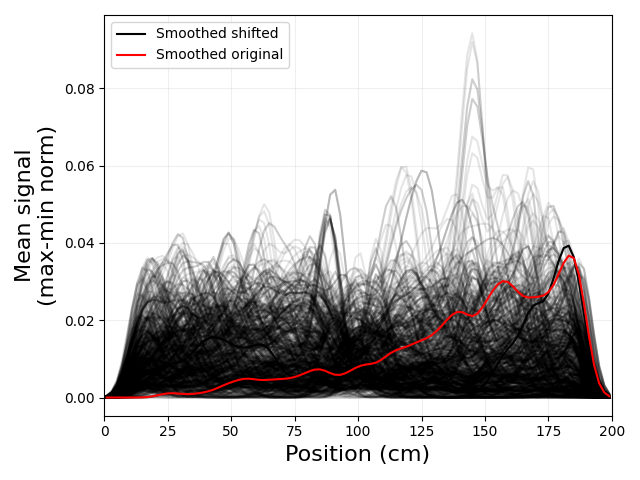

In [304]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed_shifted'].T,color = 'black',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed_shifted'][0,:],color = 'black',label='Smoothed shifted',alpha=1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed original')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


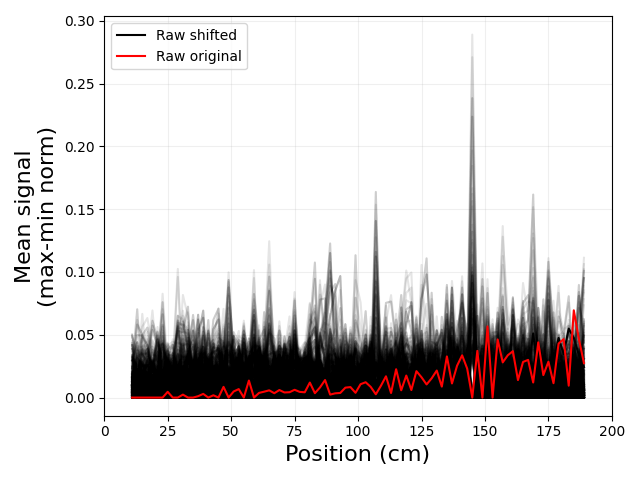

In [305]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_shifted'].T,color = 'black',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_shifted'][0,:],color = 'black',label='Raw shifted',alpha=1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'red',label='Raw original')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


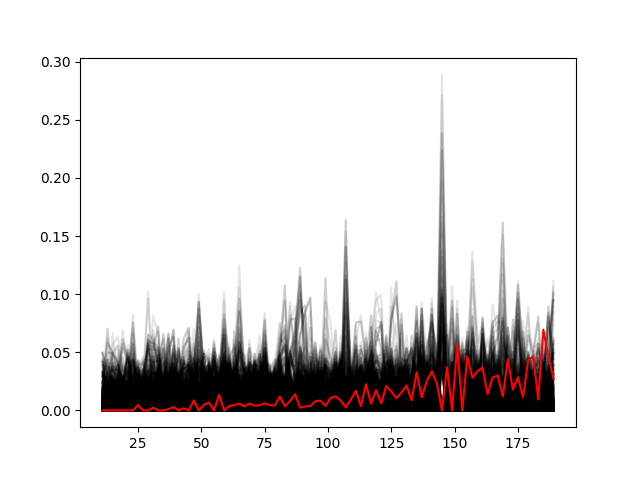

In [306]:

place_field_smoothed_shifted = place_cell_output['place_field_shifted'].copy()
place_field_smoothed = place_cell_output['place_field'].copy()
place_field_identity = place_cell_output['place_field_identity']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_field_smoothed_shifted.T,'k',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_field_smoothed,'r')
plt.plot(place_cell_output['x_center_bins'],place_field_identity+0.5,'g.',markersize=10)
plt.show()


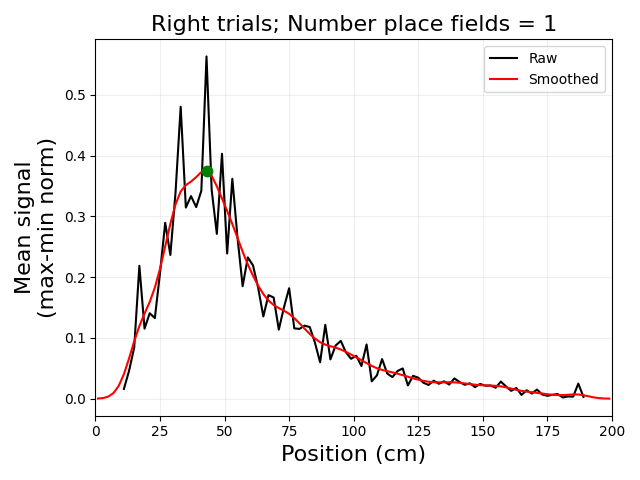

In [311]:

place_field = place_cell_output['place_field'].copy()
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()




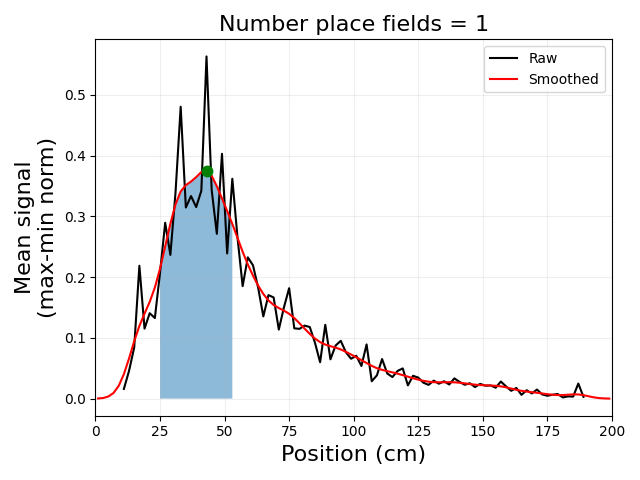

In [312]:

place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

for ii in range(place_cell_output['num_of_islands']):
    field_spread = place_cell_output['x_center_bins'][place_field_identity == ii]
    plt.fill_between(x_center_bins,place_cell_output['place_field_smoothed'],0,where = (x_center_bins >= field_spread[0]) & (x_center_bins <= field_spread[-1]),alpha=0.5)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()




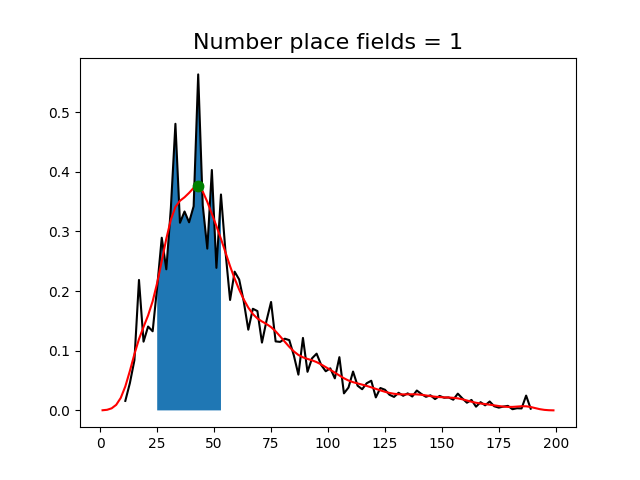

In [313]:

place_field = place_cell_output['place_field'].copy()
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(x_center_bins,place_field,'k')
plt.plot(x_center_bins,place_field_smoothed,'r')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

for ii in range(place_cell_output['num_of_islands']):
    field_spread = place_cell_output['x_center_bins'][place_field_identity == ii]
    plt.fill_between(x_center_bins,place_field,0,where = (x_center_bins >= field_spread[0]) & (x_center_bins <= field_spread[-1]))
plt.show()


In [314]:
# Place field extension relative to the whole enviroment
place_cell_output['place_cell_extension_absolute']

array([0.15])

In [315]:
# Place field extension relative to enviroment occupancy
place_cell_output['place_cell_extension_relative']


array([0.16666667])

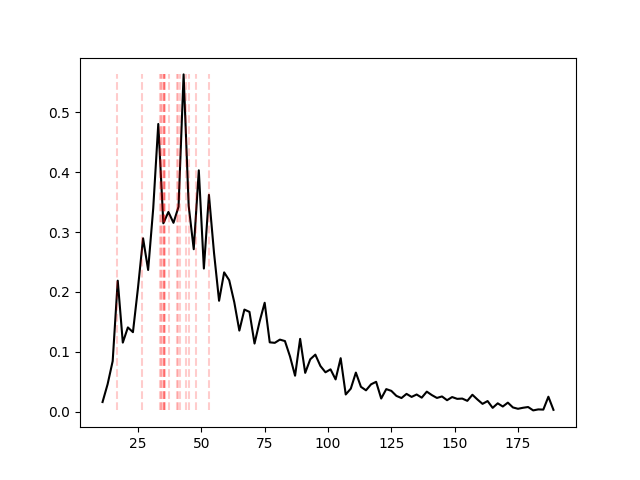

In [316]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],'k')
plt.plot([place_cell_output['x_peaks_location'],place_cell_output['x_peaks_location']],[np.nanmin(place_cell_output['place_field']),np.nanmax(place_cell_output['place_field'])],color = 'red',linestyle='--',alpha=0.2)
plt.show()


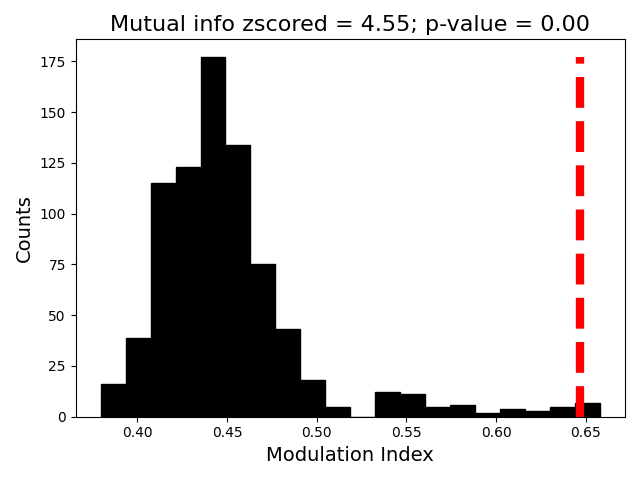

In [319]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shifted'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


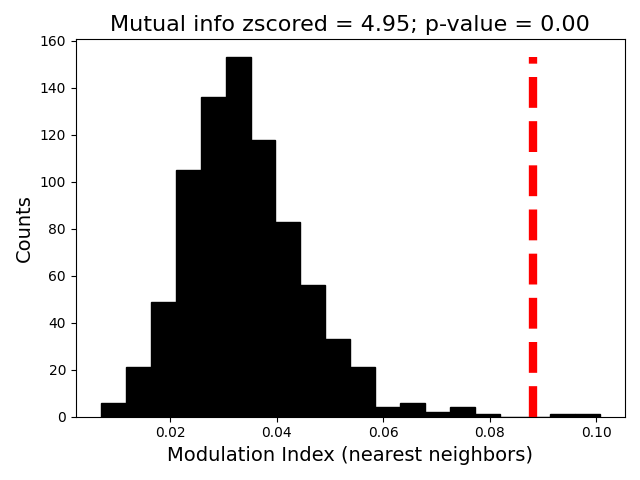

In [117]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_NN_shifted'] >= place_cell_output['mutual_info_NN_original'])/place_cell_output['mutual_info_NN_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_NN_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_NN_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_NN_original'],place_cell_output['mutual_info_NN_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['mutual_info_NN_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index (nearest neighbors)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()
